In [1]:
# Some useful settings for interactive work
%load_ext autoreload
%autoreload 2

%matplotlib widget

In [ ]:
# Import the relevant modules
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from sousvide.control.pilot import Pilot

In [3]:
cohort = "spread001"                       # cohort name

In [116]:
def extract_data(cohort, pilot, data, key=None):

    if key == None:
        key_pilot = "Jester"
    else:
        key_pilot = key

    TT,CC,Theta,ZZ,QQ = [],[],[],[],[]
    for flight in data[pilot]:
        policy = Pilot(cohort,key_pilot)
        policy.set_mode("deploy")
        test_data = torch.load(flight)

        Ndata = test_data["Xest"].shape[1]
        obj = test_data["obj"]

        if test_data["Imgs"].shape[0] != Ndata:
            Ndup = Ndata//test_data["Imgs"].shape[0]
            test_data["Imgs"] = np.repeat(test_data["Imgs"],Ndup,axis=0)

        upr = test_data["Uact"][:,0]
        theta = np.zeros((2,Ndata))
        for i in range(Ndata):
            tcr = test_data["Tact"][i]
            xcr = test_data["Xest"][:,i]
            icr = test_data["Imgs"][i,:,:,:]

            _,znn,_,_,_ = policy.OODA(upr,tcr,xcr,obj,icr,None)

            upr = test_data["Uact"][:,i]

            theta[:,i] = znn.cpu().numpy()

        c_out = np.zeros(Ndata)
        for i in range(Ndata):
            c_out[i] = theta[1,i]/theta[0,i]

        TT.append(test_data["Tact"])
        CC.append(c_out)
        Theta.append(theta)
        ZZ.append(test_data["Xest"][2,:])
        QQ.append(test_data["Xest"][6:10,:])

    return TT,CC,Theta,ZZ,QQ

def populate_plot(ax,TT,CC,title,y_flag=False):
    print(title,"-----------------------------")
    c_all = np.concatenate(CC)
    mu_c = np.around(np.mean(c_all),2)
    sm_c = np.around(np.std(c_all),2)
    print("Mean:",mu_c)
    print("Std :",sm_c)

    for i in range(len(TT)):
        ax.plot(TT[i], CC[i], color="tab:blue", alpha=0.5)

    ax.set_title(title, fontsize=16, fontweight='bold')

    if y_flag:
        ax.set_ylabel(r"$\hat{c} \ (ms^{-2})$", fontsize=16)

    stat_label = r'$\mu_\hat{c}=$'+str(mu_c)+","+r'$\sigma_\hat{c}=$'+str(sm_c)

    ax.set_xlim(0,15)
    ax.set_ylim(4,8)
    ax.axhline(y=mu_c, color='black', linestyle='--', linewidth=2, label=stat_label)
    ax.legend(fontsize=16, loc='upper right')


In [135]:
collision_traj = "flight_track_frb_v1_Jester_20241118_133107.pt"

data = {}
for entry in os.scandir(f"../cohorts/{cohort}/flight_data"):
    data_paths = []
    for root, dirs, files in os.walk(entry.path):
        for file in files:
            if file.endswith(".pt"):
                file_name = os.path.join(root, file)
                data_paths.append(file_name)

    data_paths.sort()
    data[entry.name] = data_paths

for idx,data_path in enumerate(data["cluttered"]):
    if collision_traj in data_path:
        print(idx)


10


In [6]:
TT_ap,CC_ap,Th_ap,Z_ap,_ = extract_data(cohort, "AllParameters", data, key="AllParameters")
TT_dj,CC_dj,Th_dj,Z_dj,_ = extract_data(cohort, "DirJester", data, key="DirJester")

In [7]:
TT_sim,CC_sim,_,Z_sim,_ = extract_data(cohort, "baseline_sim", data)
TT_act,CC_act,_,Z_act,_ = extract_data(cohort, "baseline", data)

In [8]:
TT_wt,CC_wt,_,Z_wt,_ = extract_data(cohort, "weight", data)
TT_lb,CC_lb,_,Z_lb,_ = extract_data(cohort, "leafblower", data)

In [9]:
TT_ls,CC_ls,_,Z_ls,Q_ls = extract_data(cohort, "cluttered_sim", data)
TT_lg,CC_lg,_,Z_lg,Q_lg = extract_data(cohort, "cluttered", data)

AllParameters -----------------------------
Mean: -2.81
Std : 9.56
DirectJester -----------------------------
Mean: 6.39
Std : 1.07


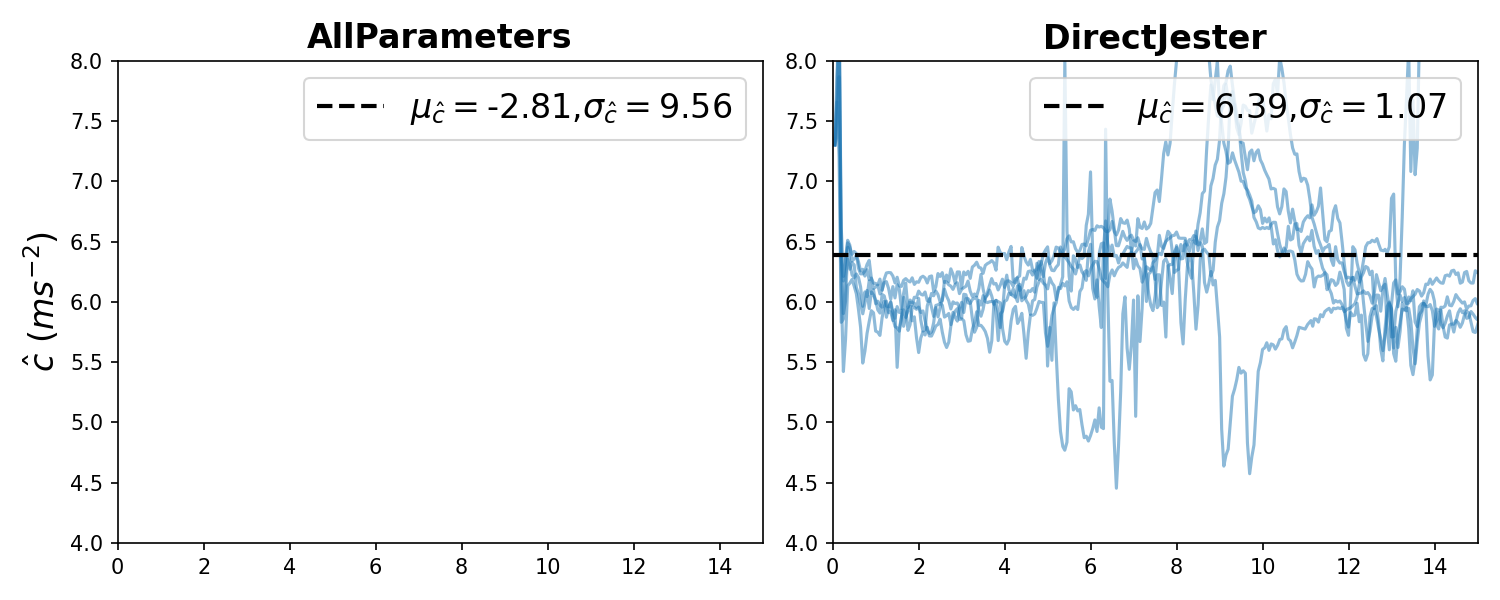

In [117]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10, 4),dpi=150)

populate_plot(axs[0],TT_ap,CC_ap,"AllParameters",y_flag=True)
populate_plot(axs[1],TT_dj,CC_dj,"DirectJester")

plt.tight_layout()
plt.show()

IDEAL: 6.031 ==============================
Simulated Flights -----------------------------
Mean: 5.98
Std : 0.17
Real-World Flights -----------------------------
Mean: 6.05
Std : 0.25


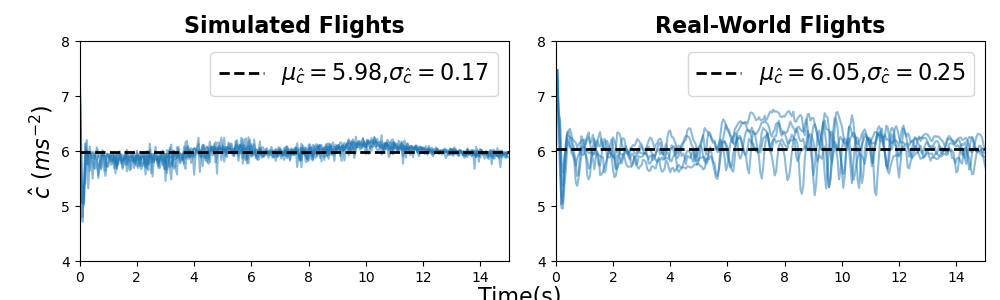

In [118]:
print("IDEAL: 6.031 ==============================")

fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10, 3))

populate_plot(axs[0],TT_sim,CC_sim,"Simulated Flights",y_flag=True)
populate_plot(axs[1],TT_act,CC_act,"Real-World Flights")

fig.text(0.52, -0.01, 'Time(s)', ha='center', fontsize=16)

plt.tight_layout()
plt.show()

plt.savefig('RealvsSim.png',dpi=300, bbox_inches = "tight")

Payload Flights -----------------------------
Mean: 5.03
Std : 0.29
Wind Flights -----------------------------
Mean: 6.05
Std : 0.3


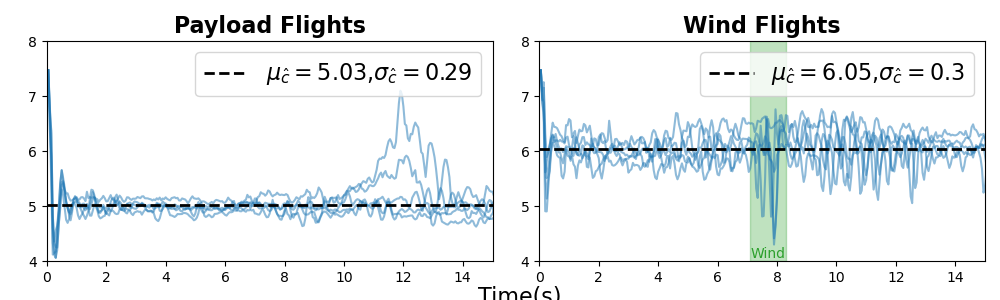

In [119]:
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10, 3))

populate_plot(axs[0],TT_wt,CC_wt,"Payload Flights")
populate_plot(axs[1],TT_lb,CC_lb,"Wind Flights")

axs[1].axvspan(7.1, 8.3, color='tab:green', alpha=0.3)
axs[1].text(7.7, axs[1].get_ylim()[0], 'Wind', color='tab:green', ha='center', va='bottom', fontsize=10)
fig.text(0.52, -0.01, 'Time(s)', ha='center', fontsize=16)

plt.tight_layout()
plt.show()

plt.savefig('DynamicDisturbances.png',dpi=300, bbox_inches = "tight")

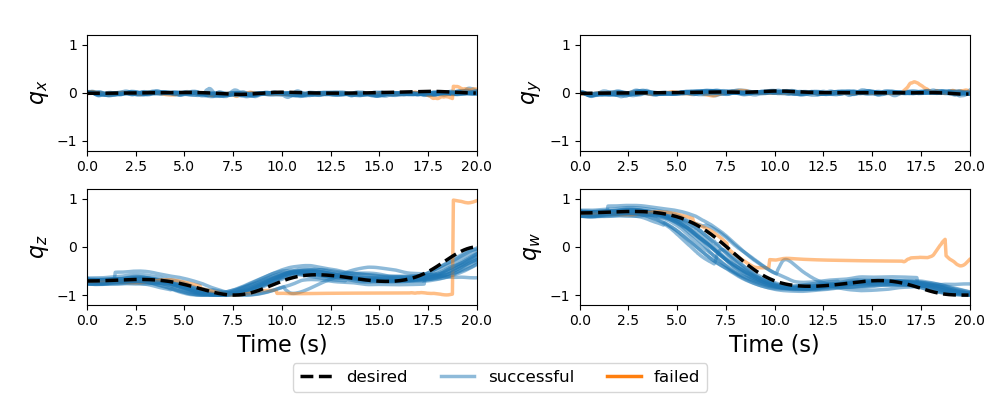

In [147]:
fig, axs = plt.subplots(2, 2, figsize=(10, 4))

axs[1, 0].set_xlabel('Time (s)', fontsize=16)
axs[1, 1].set_xlabel('Time (s)', fontsize=16)
labels = [r"$q_x$", r"$q_y$", r"$q_z$", r"$q_w$"]
for i in range(2):
    for j in range(2):
        idx = i * 2 + j
        for k in range(len(Q_lg)):
            if k == 10:
                color_choice = "tab:orange"
            else:
                color_choice = "tab:blue"

            axs[i, j].plot(TT_lg[k][0:400], Q_lg[k][idx, 0:400], color=color_choice, alpha=0.5, linewidth=2.5)
        for k in range(len(Q_ls)):
            axs[i, j].plot(TT_ls[k], Q_ls[k][idx, :], color="black", linestyle='--', linewidth=2.5)

        axs[i, j].set_ylabel(labels[idx], fontsize=16)
        axs[i, j].set_xlim(0, 20)
        axs[i, j].set_ylim(-1.2, 1.2)

axs[i, j].plot([], [], color="black", linestyle='--', linewidth=2.5, label='desired')
axs[i, j].plot([], [], color="tab:blue", alpha=0.5, linewidth=2.5, label='successful')
axs[i, j].plot([], [], color="tab:orange", linewidth=2.5, label='failed')
fig.legend(fontsize=12, loc='lower center', ncol=3)
plt.tight_layout(rect=[0, 0.07, 1, 0.95])
plt.show()

plt.savefig('ClutteredOrientation.png',dpi=300, bbox_inches = "tight")